# **IEOR 4404  Simulation (Fall 2020)**

**Homework 6  [Total points: 80 Points]**


**Due 11:59 PM, Dec 13**

Homework 6 consists of application-oriented exercises focusing on:
* `simpy` simulation of systems
* Variance reduction

The steps to finish the homework:

*   Step 1: Answer your homework on Google Colab.
*   Step 2: Submit the copy on Google Assignment

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)



In [1]:
#Your Name: Ziyang Zhang
#Your UNI: zz2732

In [2]:
#This imports all the packages you need for the homework
#Please run this first
import numpy as np


import scipy.special as spsp
import scipy.stats as spst

import matplotlib.pyplot as plt

%matplotlib inline

import sympy
!pip install simpy
import simpy
import copy
 

#Exercise 1 [30 Points]

##Setting


We are interested in simulating an application system using `simpy`. In this system, the unit of time is day, which may be non-integers.

An applicant may submit an application between $t=0$ and $t=100$. The submission time follows a homogeneous Poisson process with $\lambda=10$. Applications are then reviewed in the order that they are received. Each application needs to be reviewed by 2 people, potentially simultaneously.

At $t=90.375$ (9 am), a team of 10 admission officers will start the reviewing process. The time needed for an officer to review an application follows a uniform distribution between 0.05 and 0.1 days. After working for at least 0.375 days (9 hours), the officer will finish reviewing the current application  and then go home. Each officer resumes their work at 9 am the next day ($\lfloor t \rfloor +1.375$, where $t$ is the time that they went home).

The simulation stops when the officers finish reviewing all the applications submitted before $t=100$. 

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [25 Points]

For this system, we are interested in computing the average time between an application's submission and its review completion.

* Use `simpy` to construct the system. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system once. Inside the function print out the following information for the first 50 submissions. For each submission, print out the 4 lines containing the following information:

>* `[submission id]  [start/finish] [time]  [reviewer 1 / reviewer 2]`

>* For example:`[1] [start] [90.375] [reviwer 1]`. means applicants 1's applications review process has started at t=0.4 by reviewer 1.

> * In total, you should print out 200 lines, These 200 lines should follow chronological order (time from smallest to largest). 


[Hint 1: Since all 10 officers are the identifical. Think carefully about how you can define your resources]

[Hint 2: It is useful to start two review processes for each application. One for reviewer 1 and one for reviwer 2. The review of an application will be over when both processes are processed]

[Hint 3: There are different ways to implement the system. The sample answer relied on priority resource to define requests with a higher priority to model the time period between going home and coming back to work for each worker]




In [3]:
# include all print functions for building the system and debugging step by step

def arrival(env,desk_list):
  lmbda=10
  t=0
  i=0
  j=1
  # stop accepting applications after t=100
  while True:
    inter_arrival=-1/lmbda*np.log(np.random.rand())
    t+=inter_arrival
    if t>100:
      break
    else:
      i+=1
      # print('customer ', i, 'arrives at ', t)

  yield env.timeout(90.375)

  # start reviewing process 
  # and stop when all applications submitted before t=100 are finished
  while j<=i:
    env.process(review(env,1,j,desk_list))
    env.process(review(env,2,j,desk_list))
    j+=1


def review(env, reviewer_num, j, desk_list):
  # send 10 requests to all the officers and store the requests in a list
  rqt_list=[desk.request(priority=1) for desk in desk_list]
  # get all the available officers
  result=yield simpy.AnyOf(env, rqt_list)
  in_progress=False
  # for each officer (k+1)
  for k in range(10):
    # if officer (k+1) is available
    if rqt_list[k] in result and in_progress==False:
      # assign this available officer to the application
      in_progress=True
      index_selected=k
    # else if officer (k+1) is available, but this application is already taken by a previous officer
    elif rqt_list[k] in result and in_progress==True:
      # release the request from the user list of this available officer
      desk_list[k].release(rqt_list[k])
    # else if officer (k+1) is NOT available
    else:
      # cancel the requests from the queue list of this unavailable officer
      rqt_list[k].cancel()
  
  print('submission ', j, ' start ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # move on with the selected officer
  yield env.timeout(0.05+np.random.rand()*0.05)
  desk_list[index_selected].release(rqt_list[index_selected])
  print('submission ', j, ' finish ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # check whether current selected officer needs to go home
  # yes, if current time of the day passes 9 P.M., that is 0.375*2 days
  if env.now-int(env.now)>=0.375*2:
    # send a request with a higher priority to current server
    off=desk_list[index_selected].request(priority=0)
    # process the go-home request
    yield off
    print('officer ', index_selected+1, ' goes home at ', env.now)
    # come back to work on the second day at 9 A.M.
    yield env.timeout(1-(env.now-int(env.now))+0.375)
    # release the current server so the officer can start reviewing again
    desk_list[index_selected].release(off)
    print('officer ', index_selected+1, ' is back to work at ', env.now)  
  else:
    pass

def system():
  np.random.seed(50)
  env=simpy.Environment()
  # create 10 identical servers for 10 reviewers
  desk_list=[simpy.PriorityResource(env) for i in range(10)]
  env.process(arrival(env,desk_list))
  env.run()

In [4]:
system()

submission  1  start  90.375  reviewer  1  by officer  1
submission  1  start  90.375  reviewer  2  by officer  2
submission  2  start  90.375  reviewer  1  by officer  3
submission  2  start  90.375  reviewer  2  by officer  4
submission  3  start  90.375  reviewer  1  by officer  5
submission  3  start  90.375  reviewer  2  by officer  6
submission  4  start  90.375  reviewer  1  by officer  7
submission  4  start  90.375  reviewer  2  by officer  8
submission  5  start  90.375  reviewer  1  by officer  9
submission  5  start  90.375  reviewer  2  by officer  10
submission  5  finish  90.4257615159039  reviewer  2  by officer  10
submission  6  start  90.4257615159039  reviewer  1  by officer  10
submission  3  finish  90.43078394576852  reviewer  1  by officer  5
submission  6  start  90.43078394576852  reviewer  2  by officer  5
submission  2  finish  90.43171145255441  reviewer  2  by officer  4
submission  7  start  90.43171145255441  reviewer  1  by officer  4
submission  1  fin

In [5]:
def arrival(outputs,env,desk_list):
  lmbda=10
  t=0
  i=0
  j=1
  # stop accepting applications after t=100
  while True:
    inter_arrival=-1/lmbda*np.log(np.random.rand())
    t+=inter_arrival
    if t>100:
      break
    else:
      # store the submission time
      outputs["submission time"].append(t)
      i+=1
      # print('customer ', i, 'arrives at ', t)

  yield env.timeout(90.375)

  # start reviewing process 
  # and stop when all applications submitted before t=100 are finished
  while j<=i:
    # process for reviewer 1
    env.process(review(outputs,env,1,j,desk_list))
    # process for reviewer 2
    env.process(review(outputs,env,2,j,desk_list))
    j+=1


def review(outputs,env, reviewer_num, j, desk_list):
  # send 10 requests to all the officers and store the requests in a list
  rqt_list=[desk.request(priority=1) for desk in desk_list]
  # get all the available officers
  result=yield simpy.AnyOf(env, rqt_list)
  in_progress=False
  # for each officer (k+1)
  for k in range(10):
    # if officer (k+1) is available
    if rqt_list[k] in result and in_progress==False:
      # assign this available officer to the application
      in_progress=True
      index_selected=k
    # else if officer (k+1) is available, but this application is already taken by a previous officer
    elif rqt_list[k] in result and in_progress==True:
      # release the request from the user list of this available officer
      desk_list[k].release(rqt_list[k])
    # else if officer (k+1) is NOT available
    else:
      # cancel the requests from the queue list of this unavailable officer
      rqt_list[k].cancel()

  if j<=50:
    print('submission ', j, ' start ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # move on with the selected officer
  yield env.timeout(0.05+np.random.rand()*0.05)
  desk_list[index_selected].release(rqt_list[index_selected])

  if j<=50:
    print('submission ', j, ' finish ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # store the completion time
  if reviewer_num == 1:
    outputs['completion time 1'].append(env.now)
  else:
    outputs['completion time 2'].append(env.now)

  # check whether current selected officer needs to go home
  # yes, if current time of the day passes 9 P.M., that is 0.375*2 days
  if env.now-int(env.now)>=0.375*2:
    # send a request with a higher priority to current server
    off=desk_list[index_selected].request(priority=0)
    # process the go-home request
    yield off
    # print('officer ', index_selected+1, ' goes home at ', env.now)
    # come back to work on the second day at 9 A.M.
    yield env.timeout(1-(env.now-int(env.now))+0.375)
    # release the current server so the officer can start reviewing again
    desk_list[index_selected].release(off)
    # print('officer ', index_selected+1, ' is back to work at ', env.now)
  else:
    pass

def system():
  # initialize a dictionary for storing times
  outputs={"submission time":[], "completion time 1":[], "completion time 2":[]}

  env=simpy.Environment()
  # create 10 identical servers for 10 reviewers
  desk_list=[simpy.PriorityResource(env) for i in range(10)]
  env.process(arrival(outputs,env,desk_list))
  env.run()
  # numpy array for all the submission times
  start=np.array(outputs['submission time'])
  # numpy array for all the finish times (the maximum of 2 reviewers' finish time for each submission)
  finish=np.array(max(outputs['completion time 1'],outputs['completion time 2']))
  # compute the average time spent in the system for an application
  avg=np.mean(finish-start)
  return avg

In [6]:
# run the system once and print out the first 50 submissions' information
q1_answer = system()

submission  1  start  90.375  reviewer  1  by officer  1
submission  1  start  90.375  reviewer  2  by officer  2
submission  2  start  90.375  reviewer  1  by officer  3
submission  2  start  90.375  reviewer  2  by officer  4
submission  3  start  90.375  reviewer  1  by officer  5
submission  3  start  90.375  reviewer  2  by officer  6
submission  4  start  90.375  reviewer  1  by officer  7
submission  4  start  90.375  reviewer  2  by officer  8
submission  5  start  90.375  reviewer  1  by officer  9
submission  5  start  90.375  reviewer  2  by officer  10
submission  3  finish  90.42763664756022  reviewer  1  by officer  5
submission  6  start  90.42763664756022  reviewer  1  by officer  5
submission  3  finish  90.43295436874051  reviewer  2  by officer  6
submission  6  start  90.43295436874051  reviewer  2  by officer  6
submission  4  finish  90.43334913205769  reviewer  2  by officer  8
submission  7  start  90.43334913205769  reviewer  1  by officer  8
submission  4  fin

In [7]:
# The average time between an application's submission and its review completion
q1_answer

59.99793100238006

##Q2. [5 Points]

* Comment out the print functions. Simulate the system 3 times and print out the system output each time. Again, the system output should be the average time between an application's submission and its review completion.


In [8]:
# same functions as in EX1 Q1
# but COMMENT OUT the print functions

def arrival(outputs,env,desk_list):
  lmbda=10
  t=0
  i=0
  j=1
  # stop accepting applications after t=100
  while True:
    inter_arrival=-1/lmbda*np.log(np.random.rand())
    t+=inter_arrival
    if t>100:
      break
    else:
      # store the submission time
      outputs["submission time"].append(t)
      i+=1
      # print('customer ', i, 'arrives at ', t)

  yield env.timeout(90.375)

  # start reviewing process 
  # and stop when all applications submitted before t=100 are finished
  while j<=i:
    # process for reviewer 1
    env.process(review(outputs,env,1,j,desk_list))
    # process for reviewer 2
    env.process(review(outputs,env,2,j,desk_list))
    j+=1


def review(outputs,env, reviewer_num, j, desk_list):
  # send 10 requests to all the officers and store the requests in a list
  rqt_list=[desk.request(priority=1) for desk in desk_list]
  # get all the available officers
  result=yield simpy.AnyOf(env, rqt_list)
  in_progress=False
  # for each officer (k+1)
  for k in range(10):
    # if officer (k+1) is available
    if rqt_list[k] in result and in_progress==False:
      # assign this available officer to the application
      in_progress=True
      index_selected=k
    # else if officer (k+1) is available, but this application is already taken by a previous officer
    elif rqt_list[k] in result and in_progress==True:
      # release the request from the user list of this available officer
      desk_list[k].release(rqt_list[k])
    # else if officer (k+1) is NOT available
    else:
      # cancel the requests from the queue list of this unavailable officer
      rqt_list[k].cancel()

  # if j<=50:
  #   print('submission ', j, ' start ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # move on with the selected officer
  yield env.timeout(0.05+np.random.rand()*0.05)
  desk_list[index_selected].release(rqt_list[index_selected])

  # if j<=50:
  #   print('submission ', j, ' finish ', env.now, ' reviewer ', reviewer_num, ' by officer ', index_selected+1)

  # store the completion time
  if reviewer_num == 1:
    outputs['completion time 1'].append(env.now)
  else:
    outputs['completion time 2'].append(env.now)

  # check whether current selected officer needs to go home
  # yes, if current time of the day passes 9 P.M., that is 0.375*2 days
  if env.now-int(env.now)>=0.375*2:
    # send a request with a higher priority to current server
    off=desk_list[index_selected].request(priority=0)
    # process the go-home request
    yield off
    # print('officer ', index_selected+1, ' goes home at ', env.now)
    # come back to work on the second day at 9 A.M.
    yield env.timeout(1-(env.now-int(env.now))+0.375)
    # release the current server so the officer can start reviewing again
    desk_list[index_selected].release(off)
    # print('officer ', index_selected+1, ' is back to work at ', env.now)
  else:
    pass

def system():
  # initialize a dictionary for storing times
  outputs={"submission time":[], "completion time 1":[], "completion time 2":[]}

  env=simpy.Environment()
  # create 10 identical servers for 10 reviewers
  desk_list=[simpy.PriorityResource(env) for i in range(10)]
  env.process(arrival(outputs,env,desk_list))
  env.run()
  # numpy array for all the submission times
  start=np.array(outputs['submission time'])
  # numpy array for all the finish times (the maximum of 2 reviewers' finish time for each submission)
  finish=np.array(max(outputs['completion time 1'],outputs['completion time 2']))
  # compute the average time spent in the system for an application
  avg=np.mean(finish-start)
  return avg

In [9]:
# Simulate the system for 3 times and print out the average times
i=1
for time in [system() for i in range(3)]:
  print("Simulation ", i, " average time: ", time)
  i+=1

Simulation  1  average time:  58.32889724993675
Simulation  2  average time:  58.71292399719192
Simulation  3  average time:  57.159263545586676


# Exercise 2 [50 Points]

##Setting
A company has 10 machines. At the beginning, all 10 machines all working properly. For each machine, after $\Delta t$ hours of operating, it will break down. This inter-breakdown time $\Delta t$ follows $ Exp(\lambda=0.1)$.

When a machine breaks down, this machine will immediately be taken to the maintenance room. The maintenance room can only fix one machine at a time. The machines will be fixed following first come first serve. The time it takes to fix the machine follows $Exp(\lambda=1)$.

After the machine is fixed, the machine will be sent back to the operation room immediately to perform tasks.  After $\Delta t$ hours of operating, the machine will break down again. Again, $\Delta t \sim Exp(\lambda=0.1)$.

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [20 points]

* Simulate the system using `simpy`. The simulation should stop when the number of operating machines goes below 7. For the system output, return the length of time from $t=0$ to the end of simulation. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system 1000 times. Plot the distribution of the system output. 
* Report the lower bound, upper bound, and the length of the 95% confidence interval for the expected value of the system output.


In [10]:
# include all print functions for building the system and debugging step by step

def broken(env,maintenance,j):
  lm=0.1
  while True:
    inter_arrival=-1/lm*np.log(np.random.rand())
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    print('machine ', j, ' breaks down ', '     time: ', env.now)
    
    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j))

def repair(env, maintenance, k):
  lm=1
  # send a request to the maintenance room
  rqt=maintenance.request()
  print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  
  # raise an Interrupt error when number of broken machines exceeds 4
  if len(maintenance.queue)+len(maintenance.users)>=4:
    raise simpy.Interrupt('END !!!')

  # fix current machine when the maintenance room is available
  yield rqt
  print('machine ', k, ' is being fixed ', '     time: ', env.now)

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(np.random.rand())
  yield env.timeout(fixing_time)

  # release the machine from maintenance room
  maintenance.release(rqt)
  print('machine ', k, ' is working again ', '     time: ', env.now)
  print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)

def system_m():
  env=simpy.Environment()
  maintenance=simpy.Resource(env, capacity=1)
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1))

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now

# run the system
system_m()

machine  1  breaks down       time:  0.32720695022877355
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  1  time:  0.32720695022877355
machine  1  is being fixed       time:  0.32720695022877355
machine  9  breaks down       time:  0.4188894689912648
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  2  time:  0.4188894689912648
machine  6  breaks down       time:  0.5645655185580838
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  3  time:  0.5645655185580838
machine  2  breaks down       time:  0.6063235337580904
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  4  time:  0.6063235337580904


 The number of operating machines is below 7. Time:  0.6063235337580904


0.6063235337580904

In [11]:
# COMMENT OUT print functions
# only RETURN the time when the simulation stops
def broken(env,maintenance,j):
  lm=0.1
  while True:
    inter_arrival=-1/lm*np.log(np.random.rand())
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    # print('machine ', j, ' breaks down ', '     time: ', env.now)
    
    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j))

def repair(env, maintenance, k):
  lm=1
  # send a request to the maintenance room
  rqt=maintenance.request()
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  
  # raise an Interrupt error when number of broken machines exceeds 4
  if len(maintenance.queue)+len(maintenance.users)>=4:
    raise simpy.Interrupt('END !!!')

  # fix current machine when the maintenance room is available
  yield rqt
  # print('machine ', k, ' is being fixed ', '     time: ', env.now)

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(np.random.rand())
  yield env.timeout(fixing_time)

  # release the machine from maintenance room
  maintenance.release(rqt)
  # print('machine ', k, ' is working again ', '     time: ', env.now)
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)

def system_m():
  env=simpy.Environment()
  maintenance=simpy.Resource(env, capacity=1)
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1))

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    # print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now

# run the system once
system_m()

19.207419700268787

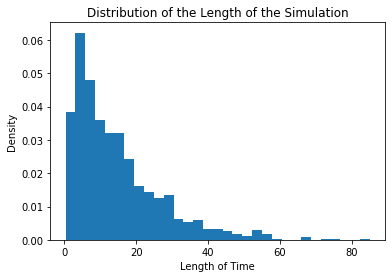

In [12]:
# Run the system 1000 times. Plot the distribution of the system output.
N=1000
samples = np.array([system_m() for _ in range(N)])
plt.hist(samples, bins=int(1000**0.5), density=True)
plt.xlabel('Length of Time')
plt.ylabel('Density')
plt.title('Distribution of the Length of the Simulation')
plt.show()

In [13]:
# Report the lower bound, upper bound, and the length of the 95% confidence interval 
# for the expected value of the system output.
mean=np.mean(samples)
std=np.std(samples,ddof=1)
lower=mean-spst.norm.ppf(0.975)*std/N**0.5
upper=mean+spst.norm.ppf(0.975)*std/N**0.5
print("95% confidence interval: ", [lower,upper])
print("mean: ", mean)
print("width of confidence interval: ",upper-lower)

95% confidence interval:  [13.740209613455441, 15.26407115322765]
mean:  14.502140383341546
width of confidence interval:  1.5238615397722093


##Q2. [10 Points]

Apply *antithetic method* to the **fixing time** and the **inter-breakdown time**. 

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.


In [14]:
def broken(env,maintenance,j, RS_s,RS_a, anti):
  lm=0.1
  while True:
    u=RS_a.rand()
    if anti==1:
      u=1-u
    inter_arrival=-1/lm*np.log(u)
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    # print('machine ', j, ' breaks down ', '     time: ', env.now)
    
    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j, RS_s,RS_a, anti))

def repair(env, maintenance, k, RS_s,RS_a, anti):
  lm=1
  # select `u` differently depending on the `anti` state
  u=RS_s.rand()
  if anti==1:
    u=1-u

  # send a request to the maintenance room
  rqt=maintenance.request()
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  
  # raise an Interrupt error when number of broken machines exceeds 4
  if len(maintenance.queue)+len(maintenance.users)>=4:
    raise simpy.Interrupt('END !!!')

  # fix current machine when the maintenance room is available
  yield rqt
  # print('machine ', k, ' is being fixed ', '     time: ', env.now)

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(u)
  yield env.timeout(fixing_time)

  # release the machine from maintenance room
  maintenance.release(rqt)
  # print('machine ', k, ' is working again ', '     time: ', env.now)
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)

def system_m(RS_s, RS_a,anti):
  env=simpy.Environment()
  maintenance=simpy.Resource(env, capacity=1)
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1, RS_s,RS_a, anti))
    # print('machine ', i+1, ' start working ', '     time: ', env.now)

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    # print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now

def system_avg():
  # Random States for `break inter_arrival time`
  RS_a_original=np.random.RandomState()
  Rs_a_anti=copy.copy(RS_a_original)
  # Random States for `repair time`:
  RS_s_original=np.random.RandomState()
  Rs_s_anti=copy.copy(RS_s_original)
  # get outputs and return the average
  output1=system_m(RS_s_original,RS_a_original, 0)
  output2=system_m(Rs_s_anti,Rs_a_anti,1)
  return (output1+output2)/2

# run the system once
system_avg()

6.994632788769592

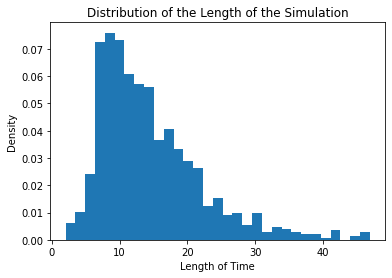

95% confidence interval:  [13.98706752799476, 14.922054845466587]
mean:  14.454561186730674
width of confidence interval:  0.9349873174718262


In [15]:
# Report the lower bound, upper bound, and the width of the 95% confidence interval 
# for the expected value of the system output.
N=1000
samples = np.array([system_avg() for _ in range(N)])
plt.hist(samples, bins=int(1000**0.5), density=True)
plt.xlabel('Length of Time')
plt.ylabel('Density')
plt.title('Distribution of the Length of the Simulation')
plt.show()
mean=np.mean(samples)
std=np.std(samples,ddof=1)
lower=mean-spst.norm.ppf(0.975)*std/N**0.5
upper=mean+spst.norm.ppf(0.975)*std/N**0.5
print("95% confidence interval: ", [lower,upper])
print("mean: ", mean)
print("width of confidence interval: ",upper-lower)

The width of the confidence interval reduces by about 0.5 compared to Q1.

The antithetic method helps reduce variance here.

##Q3. [10 Points]

Apply *control variate method* to **the fixing time of the first breakdown machine.**

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.



In [16]:
# use `the fixing time of the first breakdown machine` as the controal variate

def broken(env,maintenance,j,control_variate):
  lm=0.1
  while True:
    inter_arrival=-1/lm*np.log(np.random.rand())
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    # print('machine ', j, ' breaks down ', '     time: ', env.now)

    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j, control_variate))

def repair(env, maintenance, k, control_variate):
  lm=1
  # send a request to the maintenance room
  rqt=maintenance.request()
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  
  # raise an Interrupt error when number of broken machines exceeds 4
  if len(maintenance.queue)+len(maintenance.users)>=4:
    raise simpy.Interrupt('END !!!')

  # fix current machine when the maintenance room is available
  yield rqt
  # print('machine ', k, ' is being fixed ', '     time: ', env.now)

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(np.random.rand())
  # print('machine ', k, ' costs ', fixing_time)
  control_variate.append(fixing_time)
  yield env.timeout(fixing_time)
  

  # release the machine from maintenance room
  maintenance.release(rqt)
  # print('machine ', k, ' is working again ', '     time: ', env.now)
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)

def system_m():
  control_variate=[]
  env=simpy.Environment()
  maintenance=simpy.Resource(env, capacity=1)
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1, control_variate))
    # print('machine ', i+1, ' start working ', '     time: ', env.now)

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    # print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now, control_variate[0]

# run the system once
system_m()

(3.6201368191241245, 0.6500816488548041)

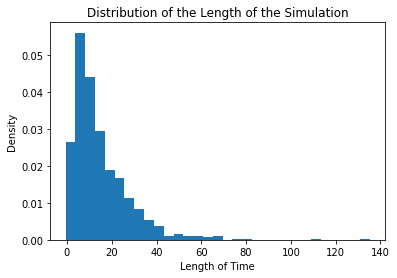

95% confidence interval:  [14.117225957379121, 15.747930549651501]
mean:  14.932578253515311
width of confidence interval:  1.6307045922723802


In [17]:
# Report the lower bound, upper bound, and the width of the 95% confidence interval 
# for the expected value of the system output.
lm=1
N=1000
result=[system_m() for i in range(N)]
result=np.array(result)
x=result[:,0]
z=result[:,1]
c=-np.cov(x,z,ddof=1)[0,1]/np.var(z,ddof=1)
mu_z=1/lm
y=x+c*(z-mu_z)

plt.hist(y, bins=int(1000**0.5), density=True)
plt.xlabel('Length of Time')
plt.ylabel('Density')
plt.title('Distribution of the Length of the Simulation')
plt.show()

mean=np.mean(y)
std=np.std(y,ddof=1)
lower=mean-spst.norm.ppf(0.975)*std/N**0.5
upper=mean+spst.norm.ppf(0.975)*std/N**0.5
print("95% confidence interval: ", [lower,upper])
print("mean: ", mean)
print("width of confidence interval: ",upper-lower)

It is NOT clear that the width of confidence interval reduce significantly compared to Q1.

Therefore, using the fixing time of the first breakdown machine as control variate does NOT help reduce variance.




##Q4.  [10 points]

Now, let's continue from Q1. Suppose the maintenance room will be closed for 0.2 hours after every 0.8 hours of opening. During this time, the repairmen will not fix any machine. After the maintenance room reopens, the repairmen will resume fixing the machines. If at the time of break, the repairmen have taken $x'$ period of time to fix a machine and the amount of the time to fix the machine is $x$, the machine will now need $x-x'$ amount of time to get fixed.

* Run the system 1000 times. Plot the distribution of the time it takes for the number of operating machines to go below 7.

[hint: one solution is to define the maintenance room as a preemptive resource, and treat closing as a request]

In [18]:
# include all print functions for building the system and debugging step by step

# `broken`: generate break arrivals for each of the 10 machines
def broken(env,maintenance,j):
  lm=0.1
  while True:
    inter_arrival=-1/lm*np.log(np.random.rand())
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    print('machine ', j, ' breaks down ', '     time: ', env.now)
    
    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j))

# `closing`: generate closing requests to the maintenance room every 0.8 hours
def closing(env, maintenance):
  while True:
    # send a request to close the maintenance room after being open for 0.8 hours
    yield env.timeout(0.8)
    # the closing request has the highest priority with preempt == True
    rqt=maintenance.request(priority=-1,preempt=True)
    yield rqt
    print('maintenance room closed ', '      time: ', env.now)
    yield env.timeout(0.2)
    # reopen the maintenance room after 0.2 hours
    maintenance.release(rqt)
    print('maintenance room reopened ', '      time: ', env.now)

def repair(env, maintenance, k):
  lm=1
  # send a request to the maintenance room
  # the repair request has the lowest priority with preempt == False
  rqt=maintenance.request(priority=1,preempt=False)

  # ignore the `closing` request in the `maintenance` user list when the maintenance room is closed
        # therefore, minus 1 when counting the total number of requests in the maintenance server
        # number of broken machines in the system = len(maintenance.queue)+len(maintenance.users)-1
  if env.now-int(env.now)>=0.8:
    print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users)-1, ' time: ', env.now)
    # raise an Interrupt error when number of broken machines exceeds 4
    if len(maintenance.queue)+len(maintenance.users)-1>=4:
      raise simpy.Interrupt('END !!!')
  else:
    print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
    # raise an Interrupt error when number of broken machines exceeds 4
    if len(maintenance.queue)+len(maintenance.users)>=4:
      raise simpy.Interrupt('END !!!')
  

  # fix current machine when the maintenance room is available
  yield rqt
  print('machine ', k, ' is being fixed ', '     time: ', env.now)
  start=env.now

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(np.random.rand())
  print('machine ', k, ' needs ', fixing_time)
  try:
    yield env.timeout(fixing_time)
    maintenance.release(rqt)
    # release the machine from maintenance room
    print('machine ', k, ' is working again ', '     time: ', env.now)
    print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  except simpy.Interrupt as Inter:
    if type(Inter.cause)==simpy.resources.resource.Preempted:
      print('machine ', k, ' gets kicked off ', '     time: ', env.now)
      # calculate the remaining fixing time needed
      remaining=fixing_time-(env.now-start)
      print('machine ', k, ' remaining time: ', remaining)
      # send another rqt to the queue with remaining fixing time
      yield env.process(finish(env,maintenance,remaining,k))

  
# `finish`: let broken machines that got kicked off on the first time finish
def finish(env,maintenance,remaining,k):
  while True:
    rqt=maintenance.request(priority=0,preempt=False)
    yield rqt
    print('machine ', k, ' is being fixed ', '     time: ', env.now)
    start=env.now
    try:
      yield  env.timeout(remaining)
      break
    except simpy.Interrupt as Inter:
      if type(Inter.cause)==simpy.resources.resource.Preempted:
        print('machine ', k, ' gets kicked off ', '     time: ', env.now)
        # calculate the remaining fixing time needed
        remaining=remaining-(env.now-start)
        print('machine ', k, ' remaining time: ', remaining)
  maintenance.release(rqt)
  print('machine ', k, ' is working again ', '     time: ', env.now)
  print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)


def system_m():
  env=simpy.Environment()
  maintenance=simpy.PreemptiveResource(env, capacity=1)
  
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1))

  # start a process that will close the maintenance room for every 0.8 hours
  env.process(closing(env, maintenance))

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now

# run the system once
system_m()

machine  6  breaks down       time:  0.25358156714069247
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  1  time:  0.25358156714069247
machine  6  is being fixed       time:  0.25358156714069247
machine  6  needs  0.11442112462227397
machine  6  is working again       time:  0.3680026917629664
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  0  time:  0.3680026917629664
maintenance room closed        time:  0.8
maintenance room reopened        time:  1.0
machine  2  breaks down       time:  1.7421070628502509
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ number of broken machines:  1  time:  1.7421070628502509
machine  2  is being fixed       time:  1.7421070628502509
machine  2  needs  2.1454142474951228
machine  2  gets kicked off       time:  1.8
machine  2  remaining time:  2.0875213103453736
maintenance room closed        time:  1.8
maintenance room reopened        time:  2.0
machine  2

6.026220667745496

In [19]:
# COMMENT OUT print functions
# only RETURN the time when the simulation stops

# `broken`: generate break arrivals for each of the 10 machines
def broken(env,maintenance,j):
  lm=0.1
  while True:
    inter_arrival=-1/lm*np.log(np.random.rand())
    # a break will arrive after some time
    yield env.timeout(inter_arrival)
    # print('machine ', j, ' breaks down ', '     time: ', env.now)
    
    # yield a `repair` process instead of processing directly
    # so that no new break will arrival before the machine is sent back from maintenance
    yield env.process(repair(env, maintenance, j))

# `closing`: generate closing requests to the maintenance room every 0.8 hours
def closing(env, maintenance):
  while True:
    # send a request to close the maintenance room after being open for 0.8 hours
    yield env.timeout(0.8)
    # the closing request has the highest priority with preempt == True
    rqt=maintenance.request(priority=-1,preempt=True)
    yield rqt
    # print('maintenance room closed ', '      time: ', env.now)
    yield env.timeout(0.2)
    # reopen the maintenance room after 0.2 hours
    maintenance.release(rqt)
    # print('maintenance room reopened ', '      time: ', env.now)

def repair(env, maintenance, k):
  lm=1
  # send a request to the maintenance room
  # the repair request has the lowest priority with preempt == False
  rqt=maintenance.request(priority=1,preempt=False)

  # ignore the `closing` request in the `maintenance` user list when the maintenance room is closed
        # therefore, minus 1 when counting the total number of requests in the maintenance server
        # number of broken machines in the system = len(maintenance.queue)+len(maintenance.users)-1

  if env.now-int(env.now)>=0.8:
    # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users)-1, ' time: ', env.now)
    # raise an Interrupt error when number of broken machines exceeds 4
    if len(maintenance.queue)+len(maintenance.users)-1>=4:
      raise simpy.Interrupt('END !!!')
  else:
    # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
    # raise an Interrupt error when number of broken machines exceeds 4
    if len(maintenance.queue)+len(maintenance.users)>=4:
      raise simpy.Interrupt('END !!!')
  

  # fix current machine when the maintenance room is available
  yield rqt
  # print('machine ', k, ' is being fixed ', '     time: ', env.now)
  start=env.now

  # spend some time fixing the machine
  fixing_time=-1/lm*np.log(np.random.rand())
  # print('machine ', k, ' needs ', fixing_time)
  try:
    yield env.timeout(fixing_time)
    maintenance.release(rqt)
    # release the machine from maintenance room
    # print('machine ', k, ' is working again ', '     time: ', env.now)
    # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)
  except simpy.Interrupt as Inter:
    if type(Inter.cause)==simpy.resources.resource.Preempted:
      # print('machine ', k, ' gets kicked off ', '     time: ', env.now)
      # calculate the remaining fixing time needed
      remaining=fixing_time-(env.now-start)
      # print('machine ', k, ' remaining time: ', remaining)
      # send another rqt to the queue with remaining fixing time
      yield env.process(finish(env,maintenance,remaining,k))

  
# `finish`: let broken machines that got kicked off on the first time finish
def finish(env,maintenance,remaining,k):
  while True:
    rqt=maintenance.request(priority=0,preempt=False)
    yield rqt
    # print('machine ', k, ' is being fixed ', '     time: ', env.now)
    start=env.now
    try:
      yield  env.timeout(remaining)
      break
    except simpy.Interrupt as Inter:
      if type(Inter.cause)==simpy.resources.resource.Preempted:
        # print('machine ', k, ' gets kicked off ', '     time: ', env.now)
        # calculate the remaining fixing time needed
        remaining=remaining-(env.now-start)
        # print('machine ', k, ' remaining time: ', remaining)
  maintenance.release(rqt)
  # print('machine ', k, ' is working again ', '     time: ', env.now)
  # print('~'*60, 'number of broken machines: ', len(maintenance.queue)+len(maintenance.users), ' time: ', env.now)


def system_m():
  env=simpy.Environment()
  maintenance=simpy.PreemptiveResource(env, capacity=1)
  
  # start a break arrival process for each of the 10 machines
  for i in range(10):
    env.process(broken(env, maintenance, i+1))

  # start a process that will close the maintenance room for every 0.8 hours
  env.process(closing(env, maintenance))

  try:
    env.run()

  # stop running the system when the simpy.Interrup error is met
  except simpy.Interrupt:
    # print('\n\n','The number of operating machines is below 7. Time: ', env.now)

    # return the time when the system stopped running
    return env.now

# run the system
system_m()

2.099366858697515

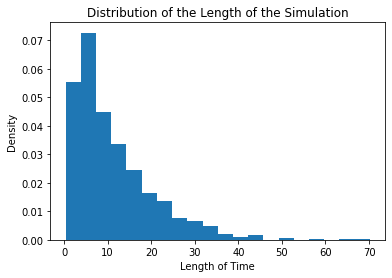

In [20]:
# Run the system 1000 times. 
# Plot the distribution of the time it takes for the number of operating machines to go below 7.
N = 1000
samples = np.array([system_m() for _ in range(N)])
plt.hist(samples, bins=20, density=True)
plt.xlabel('Length of Time')
plt.ylabel('Density')
plt.title('Distribution of the Length of the Simulation')
plt.show()

In [21]:
# Report the lower bound, upper bound, and the width of the 95% confidence interval 
# for the expected value of the system output.
mean = np.mean(samples)
std = np.std(samples,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval: ", [lower, upper])
print("mean: ", mean)
print("width of 95% confidence interval: ", upper-lower)

95% confidence interval:  [10.687017724352849, 11.825607751550013]
mean:  11.256312737951431
width of 95% confidence interval:  1.1385900271971643
